# Gas Generator Class Validationa

> Date: 27/04/2025

> Author: Elias Aoubala 

In [1]:
import handcalcs.render
from rocketcea.cea_obj_w_units import CEA_Obj
import numpy as np
import matplotlib.pyplot as plt
from turborocket.transient.start_up import GasGenerator, Pump, Turbine, LiquidValve, Cavity
from turborocket.fluids.fluids import IncompressibleFluid

## 1 - Background

This document contains the authors validation of the gas generator class of the turborocket library.
An arbitrary test case was generated, from which a comparison to the regressed results produced from turborocket is made.

## 2 - Test Case #1: Confirmation of Sizing and Throttling Functionality

This section contains an arbitrary test case setup by the author to demonstrate that the code and adjoint solves are functioning as expected.

### 2.1 - High Level Parameter Definition

**Chamber Conditions**

In [2]:
%%render sci_not param

pcc = 30e5 # Pa
mr_nom = 1
oxidiser = "N2O"
fuel = "Isopropanol"
eta_c = 0.85 
m_dot_t = 100e-3 # kg/s

<IPython.core.display.Latex object>

**Injector Conditions**

In [3]:
%%render sci_not param

p_ox_inlet = 50e5 # Pa
p_fu_inlet = 50e5 # Pa

rho_ox_inlet = 1000 # kg/m**3
rho_fu_inlet = 1000 # kg/m**3

<IPython.core.display.Latex object>

### 2.2 - System Sizing

#### 2.2.1 - Injector Sizing

We can size the injector orifice areas accordingly

In [4]:
%%render

m_dot_f = m_dot_t / (mr_nom + 1)
m_dot_ox = m_dot_t * mr_nom / (mr_nom + 1)

<IPython.core.display.Latex object>

In [5]:
%%render sci_not

cda_fu = m_dot_f / (2 * rho_fu_inlet * (p_fu_inlet - pcc))**(1/2)
cda_ox = m_dot_ox / (2 * rho_ox_inlet * (p_ox_inlet - pcc))**(1/2)

<IPython.core.display.Latex object>

#### 2.2.2 - Combustion Sizing

We can define our `CEA` object, from which we can derive our combustion conditions

In [6]:
# Define CEA Object
cea = CEA_Obj(
    oxName=oxidiser,
    fuelName=fuel,
    pressure_units="Bar",
    temperature_units="K",
    density_units="kg/m^3",
    specific_heat_units="J/kg-K",
)

We can now derive our combustion conditions:

In [7]:
%%render param sci_not

T_o = cea.get_Temperatures(Pc=pcc, MR=mr_nom)[0] * eta_c**2
gamma = cea.get_Chamber_MolWt_gamma(Pc=pcc, MR=mr_nom)[1]
cp = cea.get_Chamber_Cp(Pc=pcc, MR=mr_nom)
c_star_a = cea.get_Cstar(Pc=pcc, MR=mr_nom) * eta_c  * 0.3048

Acc = c_star_a * m_dot_t/ pcc

<IPython.core.display.Latex object>

#### 2.2.3 - Defining Throttling Parameters

In this section, we define our key throttling parameters:

In [8]:
%%render sci_not

alpha = mr_nom * ((p_fu_inlet - pcc)/(p_ox_inlet - pcc))**(1/2)

K_f = cda_fu * (2 * rho_fu_inlet)**(1/2)/Acc

<IPython.core.display.Latex object>

#### 2.2.3 - Fuel Throttle Event

We shall now consider the case where the fuel side of the injector is throttled down to 30 bar. 
We will solve for the new combustion conditions accordingly.

In [9]:
%%render sci_not param

p_ox_inlet_2 = 30e5 # Pa
p_fu_inlet_2 = 50e5 # Pa

rho_ox_inlet = 1000 # kg/m**3
rho_fu_inlet = 1000 # kg/m**3

<IPython.core.display.Latex object>

We setup our error equation, and iterate through chamber pressures till we figure out what our new setpoint is.

In [10]:
Pcc_guess = 23.44e5

In [11]:
mr_guess = alpha * ((p_ox_inlet_2 - Pcc_guess)/(p_fu_inlet_2 - Pcc_guess))**(1/2)

lhs = K_f * (
    alpha * (p_ox_inlet_2 - Pcc_guess) ** (1 / 2)
    + (p_fu_inlet_2 - Pcc_guess) ** (1 / 2)
)

print(lhs)

c_star_a = cea.get_Cstar(Pc=pcc, MR=mr_guess) * eta_c * 0.3048

print(f"C_star_a = {c_star_a}")

rhs = Pcc_guess / (c_star_a)

print(rhs)

error = abs(lhs - rhs)/lhs

print(f"Current Error: {error*100} %")

2491.345710387391
C_star_a = 936.532281321396
2502.850191872451
Current Error: 0.4617778029397195 %


We can now extract all our key properties accordingly:

In [12]:
%%render param sci_not

m_dot_ox_2 = cda_ox * (2*rho_ox_inlet * (p_ox_inlet_2 - Pcc_guess))**(1/2) # kg/s
m_dot_f_2 = cda_fu * (2 * rho_fu_inlet * (p_fu_inlet_2 - Pcc_guess)) ** (1 / 2) # kg/s

mr_new = m_dot_ox_2/m_dot_f_2 

# We can now caluate what the new combustion conditions are 
T_o_2 = cea.get_Temperatures(Pc=Pcc_guess, MR=mr_new)[0] * eta_c**2 # K
gamma_2 = cea.get_Chamber_MolWt_gamma(Pc=Pcc_guess, MR=mr_new)[1] 
cp_2 = cea.get_Chamber_Cp(Pc=Pcc_guess, MR=mr_new) # J/ kg K

ox_stiff = (p_ox_inlet_2 - Pcc_guess)/Pcc_guess
fu_stiff = (p_fu_inlet_2 - Pcc_guess)/Pcc_guess

<IPython.core.display.Latex object>

### 2.3 - Turborocket Approach

We intially define our Injector Objects

In [13]:
oxidiser = IncompressibleFluid(rho = rho_ox_inlet, P = p_ox_inlet)
fuel = IncompressibleFluid(rho = rho_fu_inlet, P = p_fu_inlet)

We can now define our gas generator object

In [14]:
GG = GasGenerator(Ox="N2O", Fu="Isopropanol", Pcc=pcc, MR=mr_nom)
GG.injector_cond(ox_in=oxidiser, fu_in=fuel, cdo=0.6, cdf=0.6)

GG.size_system(m_dot=m_dot_t, eta_c=eta_c)


{'P_cc': 3000000.0,
 'MR': np.float64(1.0),
 'T_o': np.float64(878.3712730637724),
 'Cp': np.float64(8379.753512746256),
 'gamma': np.float64(1.1658327913885558),
 'ox_stiffness': 0.6666666666666666,
 'fu_stiffness': 0.6666666666666666,
 'm_dot_t': 0.09999999999999999,
 'm_dot_o': np.float64(0.049999999999999996),
 'm_dot_f': np.float64(0.049999999999999996)}

In [15]:
GG.get_geometry()

{'CdA_ox': np.float64(7.905694150420949e-07),
 'CdA_fu': np.float64(7.905694150420949e-07),
 'A_fu': np.float64(1.3176156917368248e-06),
 'A_ox': np.float64(1.3176156917368248e-06),
 'Acc': 3.316088166195857e-05}

We can now evaluate for our throttling condition

In [16]:
oxidiser_2 = IncompressibleFluid(rho=rho_ox_inlet, P=p_ox_inlet_2)
fuel_2 = IncompressibleFluid(rho=rho_fu_inlet, P=p_fu_inlet_2)

In [17]:
GG.solve_perturb_ss(ox_in=oxidiser_2, fu_in=fuel_2)

{'P_cc': np.float64(2358085.4394021714),
 'MR': np.float64(0.4929231659930516),
 'T_o': np.float64(773.6801995387616),
 'Cp': np.float64(10210.250643911178),
 'gamma': np.float64(1.1372065379447114),
 'ox_stiffness': np.float64(0.27221853367644244),
 'fu_stiffness': np.float64(1.1203642227940707),
 'm_dot_t': np.float64(0.08579299861881949),
 'm_dot_o': np.float64(0.028326545841423988),
 'm_dot_f': np.float64(0.05746645277739551),
 'error': np.float64(2.3231104933074676e-06)}

## 3 - Test Case #2: Simulation of Transients

### 3.1 - Combustion Chamber Start-Up Transient

This section covers the analysis for the simulation of combustion transients for the engine using the turborocket model.

Firstly, inorder to do this process, we need to set an L_star to the engine.

For this test case, a **L_star of 1.5 m**.

In addition, we will assume that our intial chamber pressure is at ambient conditions, which is **1 bar**.

We will assume a 2 second ramp for the oxidiser and fuel pressures up to nominal.

In [41]:
P_ox_max = 50e5
P_fu_max = 50e5

From this, we can do a for loop to see how the system performance over time would look like.

In [42]:
T_stop = 1
T_init = 0

t_ramp = 0.5
dp = 0.01e5

GG.set_l_star(L_star=1)
GG.set_pcc_transient(P_cc_transient=1e5)

dp_dt_ox = P_ox_max/t_ramp
dp_dt_fu = P_fu_max/t_ramp

P_ox = 1.1e5
P_fu = 1.1e5

# We setup our logging array
t_array = [T_init]
Pcc_array = [1e5]
dp_dt_array = [0]
T_array = [0]
MR_array = [0]
m_dot_ox = [0]
m_dot_fu = [0]
p_ox_array = [P_ox]
p_fu_array = [P_fu]


while t_array[-1] < T_stop:

    oxidiser_tran = IncompressibleFluid(rho=rho_ox_inlet, P=P_ox)
    fuel_tran = IncompressibleFluid(rho=rho_fu_inlet, P=P_fu)

    dic =GG.transient_time_step(ox_in=oxidiser_tran, fu_in=fuel_tran, eta_c=0.85)

    # Log current state
    Pcc_array.append(dic["P_cc"])
    T_array.append(dic["T_o"])
    MR_array.append(dic["MR"])
    dp_dt_array.append(dic["dp_dt"])
    m_dot_ox.append(dic["m_dot_o"])
    m_dot_fu.append(dic["m_dot_f"])
    p_ox_array.append(P_ox)
    p_fu_array.append(P_fu)

    dp_dt = dic["dp_dt"]
    # We solve for our time step
    dt = dp/dp_dt
    if (abs(dt) > 0.1) or dt < 0:
        dt = 0.01

    t_array.append(t_array[-1]+dt)

    # We update our chamber pressure
    GG.set_pcc_transient(Pcc_array[-1] + dp_dt *  dt)

    # Update the injector
    if P_ox >= P_ox_max:
        P_ox = P_ox_max
    else:
        P_ox += dp_dt_ox * dt

    if P_fu >= P_fu_max:
        P_fu = P_fu_max
    else:
        P_fu += dp_dt_fu * dt

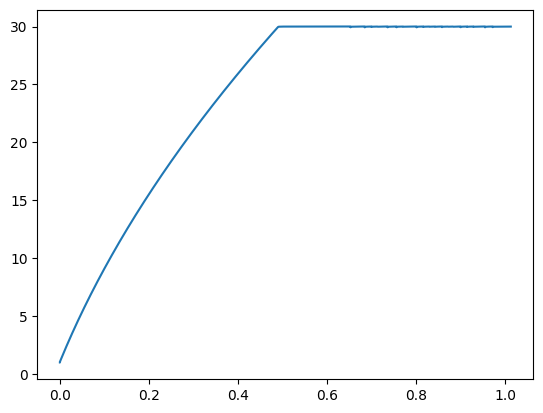

In [20]:
plt.plot(t_array, np.array(Pcc_array)/1e5)
# plt.plot(t_array, np.array(p_fu_array)/1e5)
# plt.plot(t_array, np.array(p_ox_array) / 1e5)
# plt.xlim([0,0.1])

# print(p_ox_array)

### 3.2 - Turbine

In this section, we test the turbine object to see if it is reasonable.

In [21]:
turbine = Turbine(I = 1, delta_b=140, a_rat=2, D_m=20e-2, eta=0.4)


Text(0.5, 1.0, 'Analysis of Turbine Performance as a function of Inlet Pressure')

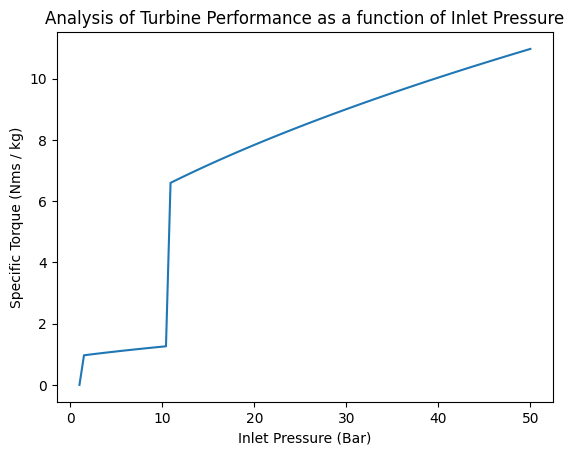

In [22]:
p_array = np.linspace(1, 50, 100) *1e5

T_o_array = np.linspace(200,1000,100)

T_array = []
P_exit = 1e5

i = 0
for p in p_array:

    T = turbine.get_torque(T_o = T_o_array[i], P_o = p, gamma=1.4, R=400, P_exit=P_exit)

    T_array.append(T)

    i +=1

plt.plot(p_array/1e5,T_array)
plt.xlabel("Inlet Pressure (Bar)")
plt.ylabel("Specific Torque (Nms / kg)")
plt.title("Analysis of Turbine Performance as a function of Inlet Pressure")


We can see the clear transition from subsonic to supersonic flow - implying the solver is working.

In reality, the transition is no where near as jumpy as seen here, but this will do for now.

### 3.3 - Liquid Valve

We will import a simple liquid valve and do a transient analysis on it to see how the expected performance of the system is like.

Text(0, 0.5, 'Valve Positon (N/D)')

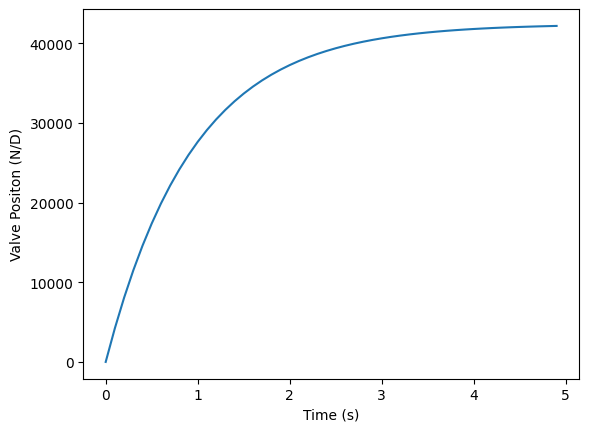

In [23]:
valve = LiquidValve(cda = 1, tau=1, s_pos_init=0)

up_str = IncompressibleFluid(rho = 100, P=100e5)
do_str = IncompressibleFluid(rho = 100, P=10e5)


m_dot_array = []
pos_array = []

dt = 0.1
t_array = np.arange(0, 5, dt)

valve.actuate(position=1)

for t in t_array:

    m_dot = valve.get_mdot(upstr=up_str, downstr=do_str)

    pos = valve.get_pos()
    
    pos_array.append(pos)
    m_dot_array.append(m_dot)

    valve.update_pos(dt=dt)

plt.plot(t_array, m_dot_array)
plt.xlabel("Time (s)")
plt.ylabel("Valve Positon (N/D)")

The first order response is demonstrated as expected.

### 3.4 - Pump

For the pump, multiple key parameters are at influence, namely the pump efficiency, the pump head vs flow rate, along with the pump torque.

We will generate plots for these accordingly.

Text(0.5, 0, 'Mass Flow (n.d)')

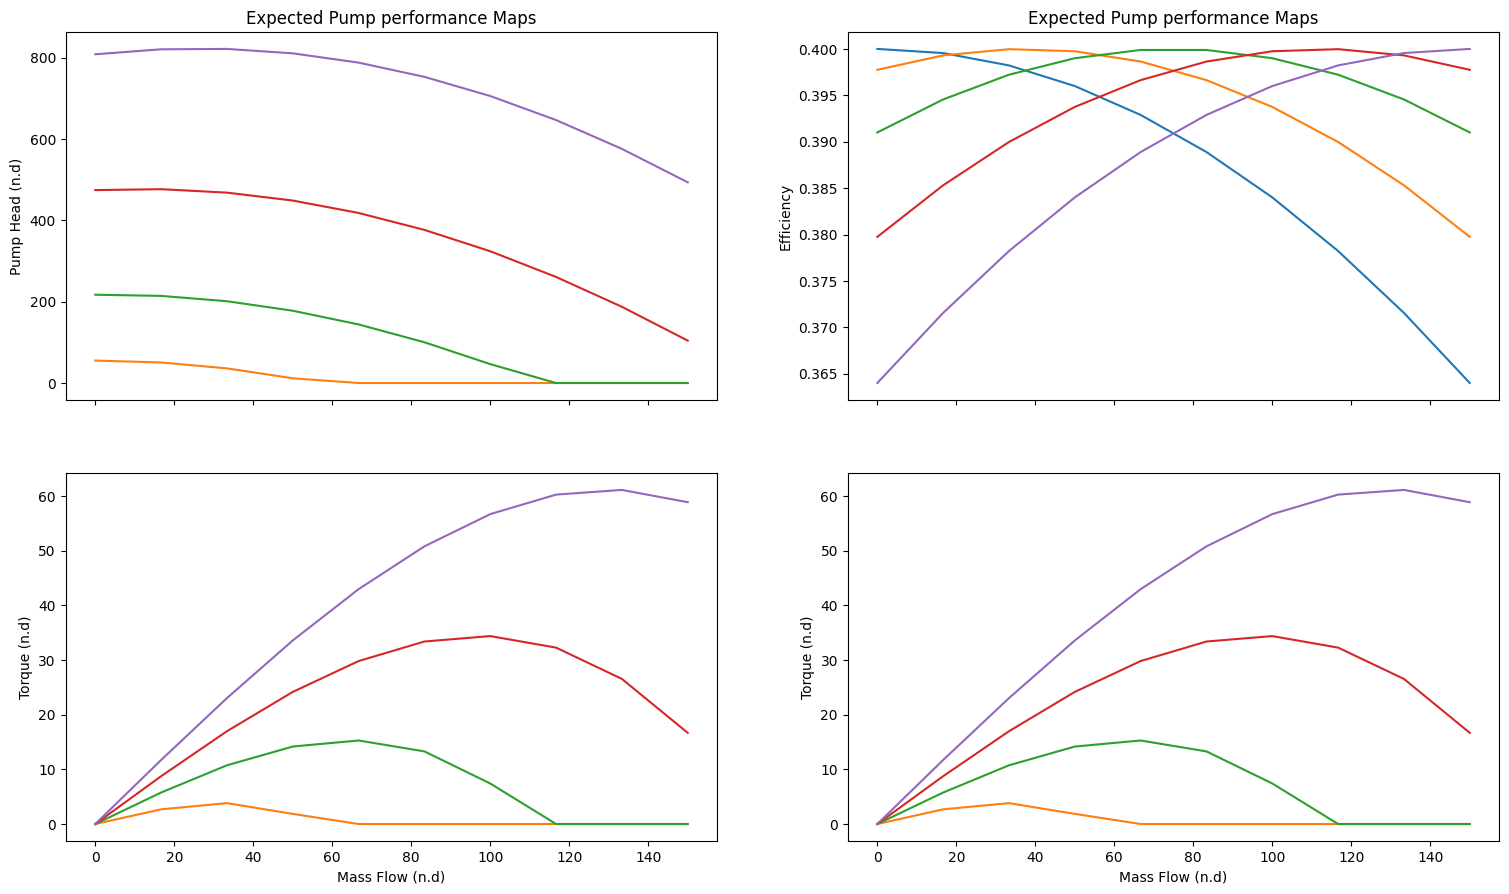

In [33]:
pump = Pump(I=1, D=3e-2, Q_nom=0.1, eta_nom=0.4, N_nom=20e3 * (2 * np.pi) / 60)

inlet = IncompressibleFluid(rho=1000, P=30e5)
k1 = 5
k2 = 10

N = np.linspace(0, 30e3, k1)*(2*np.pi)/60


m_dot = np.linspace(0, 150, k2)

N, m_dot = np.meshgrid(N, m_dot)


dp = np.zeros([k2, k1])
torque = np.zeros([k2, k1])
eta = np.zeros([k2, k1])


i = 0
for Ne in N:

    j = 0
    for m in m_dot[i,:]:
        m = m_dot[i,j]
        ne = N[i, j]

        dp[i, j] = (
            pump.get_exit_condition(inlet=inlet, N=ne, m_dot=m).get_pressure()
            - inlet.get_pressure()
        )

        torque[i, j] = pump.get_torque(inlet=inlet, N=ne, m_dot=m)

        eta[i, j] = pump.get_eta(Q=m / 1000, N = ne)

        j +=1

    i +=1

fig, ax = plt.subplots(2,2, sharex=True)
fig.set_size_inches(18.5, 10.5)
ax[0][0].plot(m_dot, dp)
ax[0][0].set_ylabel("Pump Head (n.d)")
ax[0][0].set_title("Expected Pump performance Maps")


ax[1][0].plot(m_dot, torque)
ax[1][0].set_ylabel("Torque (n.d)")
ax[1][0].set_xlabel("Mass Flow (n.d)")


ax[0][1].plot(m_dot, eta)
ax[0][1].set_ylabel("Efficiency")
ax[0][1].set_title("Expected Pump performance Maps")


ax[1][1].plot(m_dot, torque)
ax[1][1].set_ylabel("Torque (n.d)")
ax[1][1].set_xlabel("Mass Flow (n.d)")
# plt.plot(m_dot, dp)

### 3.5 - Cavity

Finally, the last component we must validate is the cavity.

In [40]:
cavity_fluid = IncompressibleFluid(rho=1000, P=1e5, B=360e6)

# We can make our volume equivalent to a 3L
V = 3e-3

cavity = Cavity(fluid = cavity_fluid, V = V)

cavity.update_pressure(m_dot=1e-3)

dp = cavity.get_fluid().get_pressure() - 1e5

print(f"Pressure Rise: {dp/1e5} Bar")

Pressure Rise: 1.2 Bar


And that is us - now we can try combining these components to see how the system responds

## 4 - System Validation

This section contains the validation done on combined systems where multiple components are being utilised.

### 4.1 - Engine with Two Main Valves.

This test case is quite simple, consisting of a main engine, with two main simple slow acting valves controlling the addition of propellant into the chamber.

We will initially define our high level fluid conditions:

**Ox**

In [2]:
%%render params sci_not

p_init = 1e5 # Pa
rho_ox = 787 # kg/m**3
B_ox = 1500e6 # Pa

<IPython.core.display.Latex object>

**Fu**

In [3]:
%%render params sci_not

p_init = 1e5 # Pa
rho_fu = 785 # kg/m**3
B_fu = 900e6 # Pa

<IPython.core.display.Latex object>

We can now instantiate our valves.

In [4]:
# We will assume a 1/4" ball valve with a 4.8 mm orifice, using a C_d of 0.8
cda_valve = 0.8*np.pi*((2e-3)/2)**2

ox_valve = LiquidValve(cda = cda_valve, tau = 150e-3, s_pos_init = 0)
fu_valve = LiquidValve(cda = cda_valve, tau = 150e-3, s_pos_init = 0)

# We will now instantiate our cavity, we will assume it's approximately half a liter
ox_injector_fluid = IncompressibleFluid(rho = rho_ox, P = p_init, B = B_ox)
fu_injector_fluid = IncompressibleFluid(rho = rho_fu, P = p_init, B = B_fu)

ox_cavity = Cavity(fluid=ox_injector_fluid, V=0.5e-3)
fu_cavity = Cavity(fluid=fu_injector_fluid, V=0.5e-3)

We need to now instantiate and size our engine automatically - based on desired inlet conditions

In [ ]:
%%render parmas sci_not

P_cc = 30e5 # Pa
MR = 3
p_ox = 50e5 # Pa
p_fu = 50e5 # Pa
m_dot = 50e-3 # g/s
eta_c = 0.85
L_star = 1.5 # m
P_cc_init = 1e5

<IPython.core.display.Latex object>

In [6]:
oxidiser = IncompressibleFluid(rho=rho_ox, P=p_ox)
fuel = IncompressibleFluid(rho=rho_fu, P=p_fu)

GG = GasGenerator(Ox="N2O", Fu="Isopropanol", Pcc=P_cc, MR=MR)

We can now start the sizing of the system.

In [7]:
GG.injector_cond(ox_in=oxidiser, fu_in=fuel, cdo=0.6, cdf=0.6)
_ =GG.size_system(m_dot=m_dot, eta_c=eta_c)
_ = GG.get_geometry()

GG.set_l_star(L_star=L_star)
GG.set_pcc_transient(P_cc_transient=P_cc_init)

ox_valve._pos = 0
fu_valve._pos = 0

ox_cavity._fluid.set_pressure(P=p_init)
fu_cavity._fluid.set_pressure(P=p_init)

We can now setup for our transient analysis!

In [8]:
ox_valve._pos = 0
fu_valve._pos = 0

T_stop = 0.5
T_init = 0

dp = 0.05e5
dt_fix = 0.01
dt_init = 1e-6

# Upstream Fluid Conditions
ox_ups = IncompressibleFluid(P = 50e5, rho = rho_ox)
fu_ups = IncompressibleFluid(P = 50e5, rho = rho_fu)

# We setup our logging array
t_array = [T_init]
Pcc_array = [P_cc_init]
dp_dt_array = [0]
T_array = [0]
MR_array = [0]
m_ox_array = [0]
m_fu_array = [0]

ox_valve_array = [0]
fu_valve_array = [0]

p_ox_array = [ox_cavity.get_fluid().get_pressure()]
p_fu_array = [fu_cavity.get_fluid().get_pressure()]

# Initialising
dt = dt_init

ox_valve.actuate(position=1)
fu_valve.actuate(position=1)

while t_array[-1] < T_stop:

    # Firstly we need to update the valve positions
    ox_valve.update_pos(dt = dt)
    fu_valve.update_pos(dt = dt)

    # Now we need to evaluate for the mass-flow through the valves
    m_dot_ox = ox_valve.get_mdot(upstr=ox_ups, downstr=ox_cavity.get_fluid(), dt=dt)
    m_dot_fu = fu_valve.get_mdot(upstr=fu_ups, downstr=fu_cavity.get_fluid(), dt=dt)

    # We can get our injector fluid objects
    inj_ox = ox_cavity.get_fluid()
    inj_fu = fu_cavity.get_fluid()

    # We can do the combustion analysis of the chamber to see how our pressure rise is
    dic = GG.transient_time_step(ox_in = inj_ox, fu_in = inj_fu, eta_c=0.85)

    # We need to now withrdraw from the injector cavitieis

    # We update our cavity
    m_ox_cav = (m_dot_ox - dic["m_dot_o"])*dt
    m_fu_cav = (m_dot_fu - dic["m_dot_f"])*dt

    ox_cavity.update_pressure(m_dot=m_ox_cav)
    fu_cavity.update_pressure(m_dot=m_fu_cav)

    # Log current state
    Pcc_array.append(dic["P_cc"])
    T_array.append(dic["T_o"])
    MR_array.append(dic["MR"])
    dp_dt_array.append(dic["dp_dt"])

    m_ox_array.append(dic["m_dot_o"])
    m_fu_array.append(dic["m_dot_f"])

    p_ox_array.append(inj_ox.get_pressure())
    p_fu_array.append(inj_fu.get_pressure())

    ox_valve_array.append(m_dot_ox)
    fu_valve_array.append(m_dot_fu)

    dp_dt = dic["dp_dt"]
    # We solve for our time step

    dp_dt_ox = (p_ox_array[-2] - p_ox_array[-1]) / dt

    dp_dt_fu = (p_fu_array[-2] - p_fu_array[-1]) / dt

    dp_dt_time = max(abs(dp_dt), abs(dp_dt_ox), abs(dp_dt_fu))

    if dp_dt_time == 0:
        dt = dt_fix
    else:
        dt = dp / dp_dt_time

    if (abs(dt) > dt_fix):
        dt = dt_fix

    t_array.append(t_array[-1] + dt)

    # We update our chamber pressure
    GG.set_pcc_transient(Pcc_array[-1] + dp_dt * dt)

    print(f"Current Timestep = {t_array[-1]}")

print(Pcc_array)

0.0
0.0
Current Timestep = 0.01
0.02206986778426309
0.022041806911142322
Current Timestep = 0.010089124018904647
0.021892600999153706
0.021864759259538433
Current Timestep = 0.010098633389726481
-0.12550809736825252
-0.06610733823570428
Current Timestep = 0.01010822758513163
-0.012863087826638227
-0.006498225695320792
Current Timestep = 0.010117900644710114
0.04775041075903374
0.03359642798769275
Current Timestep = 0.010127654694004137
0.03463161962874191
0.028762371260240435
Current Timestep = 0.010137491896029709
0.016425290394301382
0.01794061209558891
Current Timestep = 0.010147414461488983
0.015185450096149638
0.016509483515572194
Current Timestep = 0.01015742465127497
0.019277883251709312
0.018710977516486562
Current Timestep = 0.010167524781860166
0.020524944576487413
0.019536368146490363
Current Timestep = 0.010177717231917023
0.019815252354202745
0.01919228897547873
Current Timestep = 0.010188004448956987
0.01932533283313803
0.018900681429584853
Current Timestep = 0.0101983889

(0.0, 10.0)

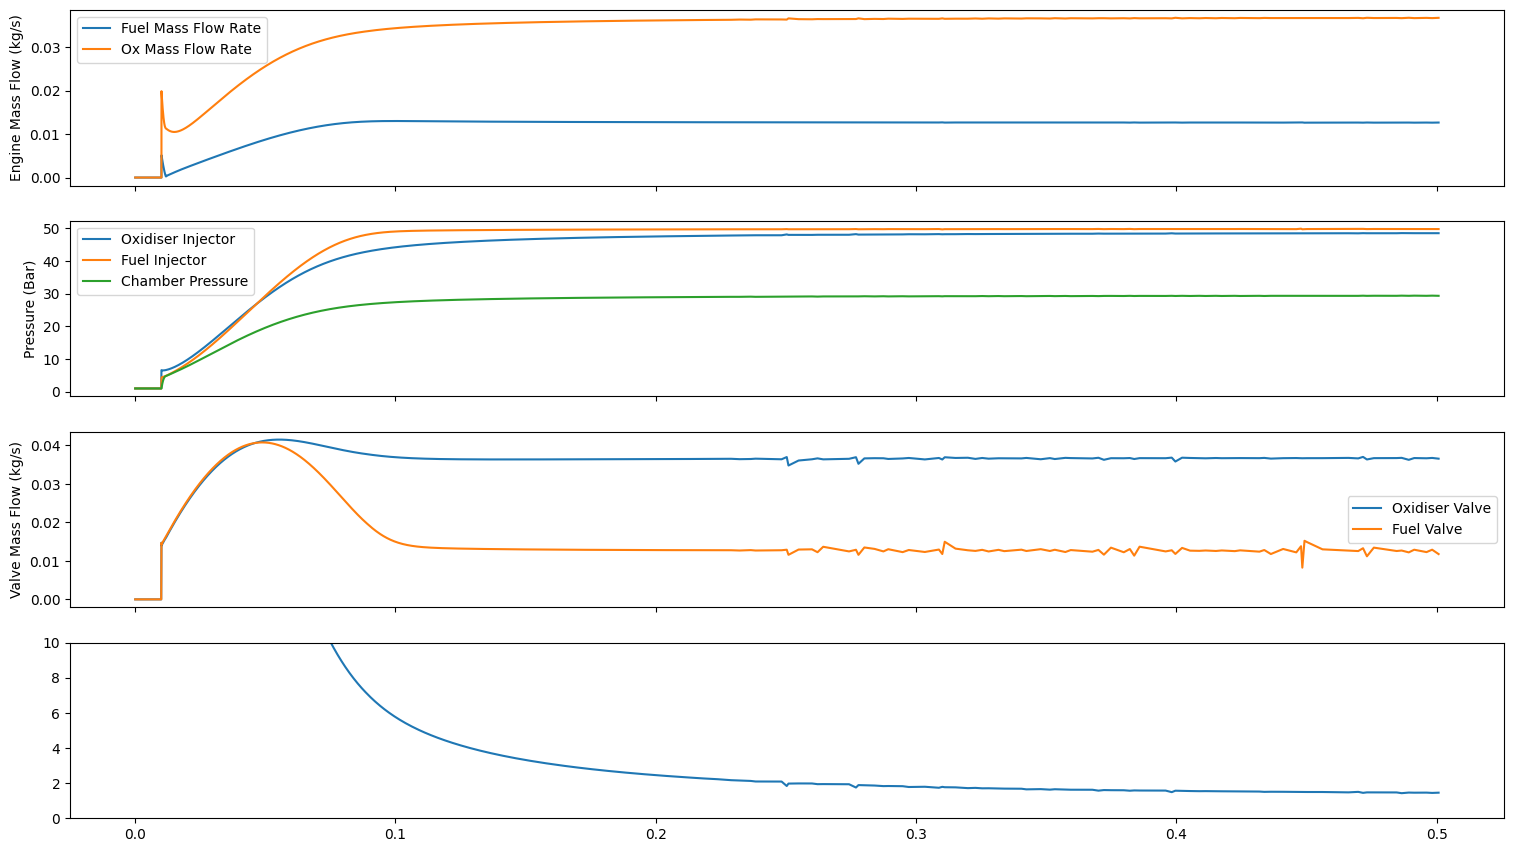

In [9]:
fig, ax = plt.subplots(4, sharex=True)

fig.set_size_inches(18.5, 10.5)

ax[0].plot(t_array, m_fu_array, label="Fuel Mass Flow Rate")
ax[0].plot(t_array, m_ox_array, label="Ox Mass Flow Rate")

ax[0].legend()
ax[0].set_ylabel("Engine Mass Flow (kg/s)")

ax[1].plot(t_array, np.array(p_ox_array) / 1e5, label="Oxidiser Injector")
ax[1].plot(t_array, np.array(p_fu_array) / 1e5, label="Fuel Injector")
ax[1].plot(t_array, np.array(Pcc_array) / 1e5, label="Chamber Pressure")
# plt.plot(t_array, ox_valve_array, label = "Oxidiser Valve")
# plt.plot(t_array, fu_valve_array, label = "Fuel Valve")
ax[1].legend()
ax[1].set_ylabel("Pressure (Bar)")

ax[2].plot(t_array, ox_valve_array, label = "Oxidiser Valve")
ax[2].plot(t_array, fu_valve_array, label = "Fuel Valve")
ax[2].legend()
ax[2].set_ylabel("Valve Mass Flow (kg/s)")

ax[3].plot(t_array, (50e5 - np.array(p_ox_array))/1e5)
ax[3].set_ylim([0,10])
# ax[3].set_xlim([0.01,0.012])

## 3 - Appendix A: Comparison of c_star approach vs T_o directly

A comparison is made between the two approaches for getting the gas temperature, namely the direct approach and c_star approach.

In [25]:
eta_c = 1
t_a = []
t_o = []
gamma_a = []
mr = np.linspace(0.5,2, 100)
pc = 30e5

for of in mr:

    c_star = cea.get_Cstar(Pc=pc, MR=of) * 0.3048
    c_star_a = c_star *eta_c

    gamma = cea.get_Chamber_MolWt_gamma(Pc=pc, MR=of)[1]

    gamma_a.append(gamma)

    param = (2 / (gamma + 1))**((gamma + 1)/(-2 * (gamma - 1)))

    R = 8314 / cea.get_Chamber_MolWt_gamma(Pc=pc, MR=of)[0]
    # print(R)

    t_a.append((gamma/ (R))*(c_star_a / param)**2) 

    t_o.append((cea.get_Temperatures(Pc=pc, MR=of, frozen=1)[0]))

Text(0.5, 0, 'Mixture Ratio ($\\frac{\\dot{m}_{ox}}{\\dot{m}_{fu}}$)')

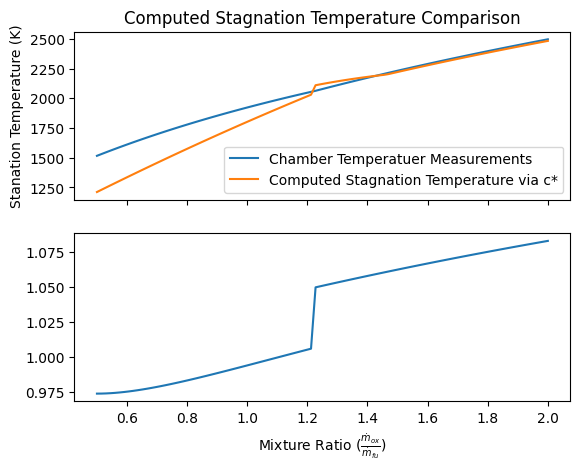

In [26]:
fix, ax = plt.subplots(2, 1, sharex=True)

ax[0].plot(mr , t_o, label="Chamber Temperatuer Measurements")
ax[0].plot(mr, t_a, label="Computed Stagnation Temperature via c*")
ax[0].set_ylabel("Stanation Temperature (K)")
ax[0].set_title("Computed Stagnation Temperature Comparison")
ax[0].legend()

ax[1].plot(mr, gamma_a, label="Chamber Temperatuer Measurements")
ax[1].set_xlabel(r"Mixture Ratio ($\frac{\dot{m}_{ox}}{\dot{m}_{fu}}$)")

As can be seen, at a mixture ratio of about 1.2, the specific heat ratio drops suddenly - resulting in a divergence in the two sets of results.

Let us now consider the case where instead of using chamber combustion conditions, we use the combustion conditions at the throat to figure out what our stagnation temperature is.

In [27]:
eta_c = 1
t_a = []
t_o = []
gamma_a = []
mr = np.linspace(0.5, 2, 100)
pc = 30e5

for of in mr:

    c_star = cea.get_Cstar(Pc=pc, MR=of) * 0.3048
    c_star_a = c_star * eta_c

    gamma = cea.get_Throat_MolWt_gamma(Pc=pc, MR=of)[1]

    gamma_a.append(gamma)

    param = (2 / (gamma + 1)) ** ((gamma + 1) / (-2 * (gamma - 1)))

    R = 8314 / cea.get_Throat_MolWt_gamma(Pc=pc, MR=of)[0]

    t_a.append((gamma / (R)) * (c_star_a / param) ** 2)

    t_o.append((cea.get_Temperatures(Pc=pc, MR=of)[0]))

Text(0.5, 0, 'Mixture Ratio ($\\frac{\\dot{m}_{ox}}{\\dot{m}_{fu}}$)')

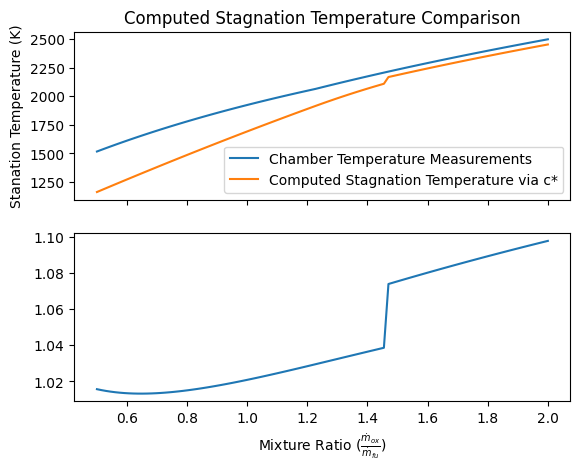

In [28]:
fix, ax = plt.subplots(2, 1, sharex=True)

ax[0].plot(mr, t_o, label="Chamber Temperature Measurements")
ax[0].plot(mr, t_a, label="Computed Stagnation Temperature via c*")
ax[0].set_ylabel("Stanation Temperature (K)")
ax[0].set_title("Computed Stagnation Temperature Comparison")
ax[0].legend()

ax[1].plot(mr, gamma_a, label="Chamber Temperatuer Measurements")
ax[1].set_xlabel(r"Mixture Ratio ($\frac{\dot{m}_{ox}}{\dot{m}_{fu}}$)")

A similar divergence can be seen, howeever this pccurs at a higher O/F.

If we plotted this against the temperature that is local to the throat, we may improve the siutation.

In [29]:
eta_c = 1
t_a = []
t_o = []
gamma_a = []
mr = np.linspace(0.5, 2, 100)
pc = 30e5

for of in mr:

    c_star = cea.get_Cstar(Pc=pc, MR=of) * 0.3048
    c_star_a = c_star * eta_c

    gamma = cea.get_Throat_MolWt_gamma(Pc=pc, MR=of)[1]

    gamma_a.append(gamma)

    param = (2 / (gamma + 1)) ** ((gamma + 1) / (-2 * (gamma - 1)))

    R = 8314 / cea.get_Throat_MolWt_gamma(Pc=pc, MR=of)[0]

    t_a.append((gamma / (R)) * (c_star_a / param) ** 2)

    t_o.append((cea.get_Temperatures(Pc=pc, MR=of)[1]))

Text(0.5, 0, 'Mixture Ratio ($\\frac{\\dot{m}_{ox}}{\\dot{m}_{fu}}$)')

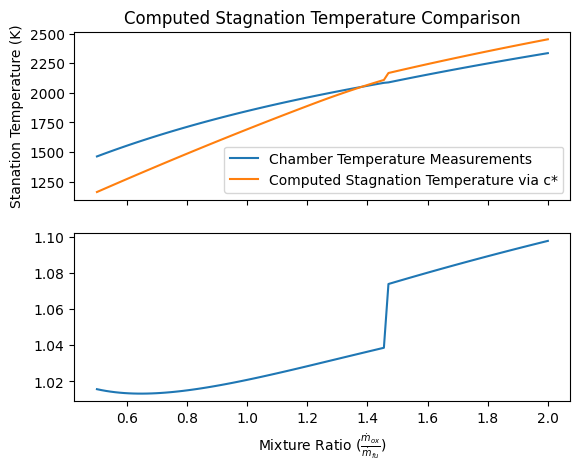

In [30]:
fix, ax = plt.subplots(2, 1, sharex=True)

ax[0].plot(mr, t_o, label="Chamber Temperature Measurements")
ax[0].plot(mr, t_a, label="Computed Stagnation Temperature via c*")
ax[0].set_ylabel("Stanation Temperature (K)")
ax[0].set_title("Computed Stagnation Temperature Comparison")
ax[0].legend()

ax[1].plot(mr, gamma_a, label="Chamber Temperatuer Measurements")
ax[1].set_xlabel(r"Mixture Ratio ($\frac{\dot{m}_{ox}}{\dot{m}_{fu}}$)")

Now let's consider the case where we need to figure out what our stagnation temperature is at the outlet of our engine - lets compare the two approaches we have designed:

In [31]:
eta_c = 0.85
t_a = []
t_o = []

t_ac = []
t_oc = []

gamma_a = []
mr = np.linspace(0.5, 2, 100)
pc = 30e5

for of in mr:

    c_star = cea.get_Cstar(Pc=pc, MR=of) * 0.3048
    c_star_a = c_star * eta_c

    gamma = cea.get_Chamber_MolWt_gamma(Pc=pc, MR=of)[1]

    gamma_a.append(gamma)

    param = (2 / (gamma + 1)) ** ((gamma + 1) / (-2 * (gamma - 1)))

    R = 8314 / cea.get_Chamber_MolWt_gamma(Pc=pc, MR=of)[0]

    t_a.append((gamma / (R)) * (c_star / param) ** 2)
    t_ac.append((gamma / (R)) * (c_star_a / param) ** 2)

    t_o.append((cea.get_Temperatures(Pc=pc, MR=of, frozen=1)[0]))
    t_oc.append((cea.get_Temperatures(Pc=pc, MR=of, frozen=1)[0] * eta_c**2))

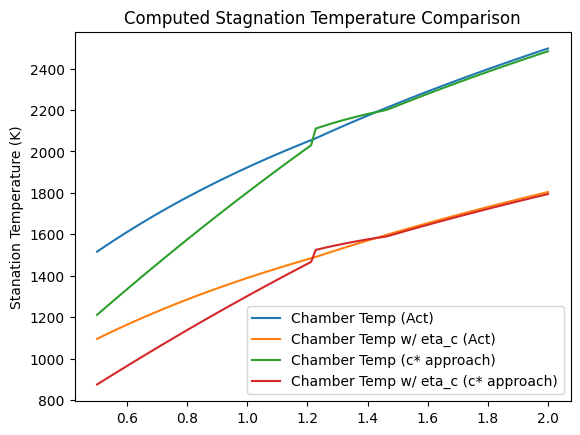

In [32]:
fix, ax = plt.subplots(1, 1, sharex=True)

ax.plot(mr, t_o, label="Chamber Temp (Act)")
ax.plot(mr, t_oc, label="Chamber Temp w/ eta_c (Act)")

ax.plot(mr, t_a, label="Chamber Temp (c* approach)")
ax.plot(mr, t_ac, label="Chamber Temp w/ eta_c (c* approach)")

ax.set_ylabel("Stanation Temperature (K)")
ax.set_title("Computed Stagnation Temperature Comparison")
ax.legend()

In conclusion, the c_star approach will be used for the sizing of the throat and such parameters, however the actual approach will be used for the combustion modelling of the temperatuer.